# Q2

In [137]:
from scipy.integrate import solve_bvp
from scipy.integrate import solve_ivp
from scipy.integrate import simpson
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from tabulate import tabulate

### Boundary Value Problem

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          4.77e-07       0.00e+00         1000             0       
Solved in 1 iterations, number of nodes 1000. 
Maximum relative residual: 4.77e-07 
Maximum boundary residual: 0.00e+00


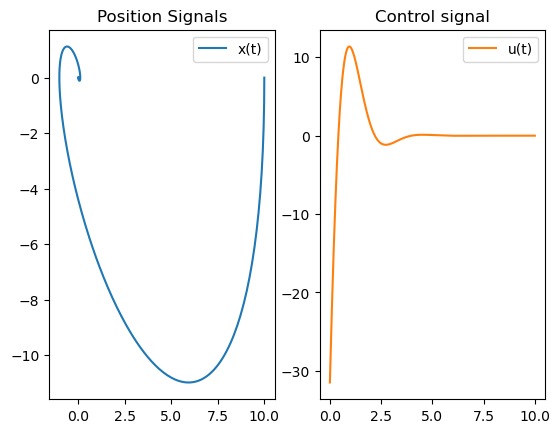

In [2]:
#Create our independent variable nodes. 
t = np.linspace(0,10,1000)
dt = 10/1000

#Create our matrices.
A = np.array([[0, 1],
            [-1.6, -0.4]])

B = np.array([[0], 
              [1]])

Q = np.array([[2, 0],
            [0, 0.01]])

R = np.array([0.1])

P1 = np.array([[1, 0],
            [0, 0.01]])

# The order that we implement this is crucial. In this case, 
# we will solve the xdot function first.

## Create our function

#Reshape because numpy reads the matrix as a (R,) instead of a (R,1) which throws an error.
#None created a Row vector when placed before, and a Column vector when placed after. Replaces the "lost" axis when slicing.
def bvp(x,y):
    return np.vstack((A[None,0] @ np.vstack([y[0],y[1]]) - ((B @ (1/R)).reshape(2,1) @ B.T)[None,0] @ np.vstack([y[2],y[3]]), ##x_dot1 
                      A[None,1] @ np.vstack([y[0],y[1]]) - ((B @ (1/R)).reshape(2,1) @ B.T)[None,1] @ np.vstack([y[2],y[3]]), ##x_dot2
                     -Q[None,0] @ np.vstack([y[0],y[1]]) - A.T[None,0] @ np.vstack([y[2],y[3]]),   ##p_dot1
                     -Q[None,1] @ np.vstack([y[0],y[1]]) - A.T[None,1] @ np.vstack([y[2],y[3]]),   ##p_dot2
                     ))

#Create our boundary conditions
def bc(ya, yb):
    return np.array([ya[0] - 10,
                     ya[1],
                     yb[2] - (P1.T[0] @ np.vstack([yb[0],yb[1]]))[0], #Indexing prevents any deprecation issues in NumPy
                     yb[3] - (P1.T[1] @ np.vstack([yb[0],yb[1]]))[0]
                    ])
#Create our guess 
y = np.zeros((4,t.size))

#Call our function
sol = solve_bvp(bvp, bc, t, y, verbose=2) #Change verbosity to have an idea of the kind of 

#Create our solution arrays
xsol = sol.y[(0,1),:]
psol = sol.y[(2,3),:] 
usol = -(1/R) @ B.T @ psol #row vector.

#Plot the x and u control signals. 
fig, axs = plt.subplots(1,2)
axs[0].plot(xsol[0],xsol[1], label="x(t)")
# axs[0].plot(t,xsol[1], "tab:red", label="x2(t)")
axs[0].set_title("Position Signals")
axs[0].legend()

#Plotting the control signal 
axs[1].plot(t, usol, "tab:orange", label="u(t)")
axs[1].set_title("Control signal")
axs[1].legend()

### Directional Derivatives

In [138]:
## Create the v function with parameter inputs.
def v(t_step, a, b, c, d):
    return np.array([a * math.sin(b * t_step + c) + d])

def z_fun(t,y):
    v = a * math.sin(b * t + c) + d
    return np.array([A @ y + B * v])
    
#Initialize our difference vector
diff_vec = []
direc_vec = []
for j in range(10):
    ##Seed our random numbers and generate the v parameters. 
    random.seed()
    a = random.uniform(0,10)
    b = random.uniform(0,10)
    c = random.uniform(0,10)
    d = random.uniform(0,10)

    ##Initialize perturbation vectors.
    z = np.zeros((2, t.size))
    vv = np.zeros((t.size))

    ##Simulate the z vector forward using z_dot = A*z + B*v. Simulate it using solve_ivp
    solivp = solve_ivp(z_fun,[0,10],z[:,0],t_eval= t,vectorized = True)
    z = solivp.y

    for i in range(len(t)-1):
        #Assign values to the v_vector
        vv[i] = v(t[i], a, b, c, d)    

    #Now that we have z based on v, we can solve the directional derivative.
    #Initialize an array for the integral at each timestep.
    integral = np.zeros((t.size))
    for ii in range(len(t)):
        #Calculate the integral at each timestep. 
        integral[ii] = (xsol[:,ii,None].T @ Q @ z[:,ii,None])[0] + usol[ii] * R * vv[ii]  

    difference = simpson(integral,t) + xsol[:,-1,None].T @ P1 @ z[:,-1,None]
    diff_vec.append([difference[0,0],"{:.2f} sin({:.2f}t + {:.2f}) + {:.2f}".format(a,b,c,d)])
    
#Tabulate the data 
col_names = ["",""]

In [136]:
diff_vec

[[0.003118043388216907, '1.73 sin(6.63t + 8.88) + 7.76'],
 [-0.0015219836765979356, '6.99 sin(3.77t + 2.66) + 6.81'],
 [-0.0003427753630909913, '3.79 sin(8.49t + 3.39) + 2.61'],
 [0.0005907650233178701, '3.33 sin(1.28t + 9.41) + 1.88'],
 [-0.005407797135097245, '7.15 sin(2.46t + 4.00) + 8.02'],
 [0.0010550418149223018, '0.77 sin(3.90t + 0.04) + 5.28'],
 [-0.00012079576155622048, '3.35 sin(6.28t + 3.17) + 0.83'],
 [-0.0003621664187476521, '7.69 sin(3.88t + 2.65) + 1.12'],
 [4.4217652538295066e-05, '6.39 sin(0.06t + 8.25) + 4.92'],
 [0.0020056973754924543, '8.96 sin(4.24t + 6.12) + 1.83']]

In [113]:
range(10)[-1]


9